In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels as sm

import seaborn as sns
import pyreto

<h1>Exactly how big are U.S. banks?</h1>

<h3>Dr. David R. Pugh</h3>

<img src="./assets/img/kapsarc-logo.png" alt="KAPSARC">
<h4>London, United Kingdom, 19 March 2016</h4>

<img src="../../assets/img/INET_Brand_Final-01.png" alt="Institute for New Economic Thinking" width=500>

<h1> Motivation </h1>

I am currently leading the development of a community driven, open-source project to develop scalable, data-driven, and reproducible agent-based models (ABMs) of economic systems called <a href="http://scalabm.github.io/">ScalABM</a>. Banks are important part of modern economic systems and I would like our banking sector to be realistically calibrated.

<strong>Primary motivation is to establish "facts on the ground" concerning the distribution of U.S. banks and how it has evolved (or not!) over time as a precursor to calibrating my simulation models.</strong>

<h2>I have a hypothesis!</h2>

I suspect that the upper tail of the bank size distribution might follow a power law...

$$ p(x; x_{min}, \alpha) = \left(\frac{\alpha - 1}{x_{min}}\right)\left(\frac{x_{min}}{x}\right)^{\alpha} $$

...more specifically, I think that Zipf's Law (i.e., power law with $\alpha = 2$) is a pretty decent null hypothesis.

<h2> Why Zipf's Law? </h2> 

Strong empirical evidence from <a href="http://www.uvm.edu/~pdodds/files/papers/others/2001/axtell2001a.pdf">Axtell (<em>Science</em>, 2001)</a> (and <em>many</em> others!) that distribution of <em>firm sizes</em> is well decribed by Zipf's Law. Maybe banks are like firms?

<h1> Data </h1>

<h3> Statistics on Depository Institutions </h3>

<p>Data used in this study are taken from the <a href="http://www2.fdic.gov/sdi/index.asp">Statistics on Depository Institutions (SDI)</a> database maintained by the U.S. Federal Deposit Insurance Corporation (FDIC).<p>

SDI data set contains aggregate demographic and financial information about the U.S. banking sector, as well detailed <em>quarterly</em> data on individual bank (or bank holding company) balance sheets, income statements, performance ratios, etc., dating back to 1992.

<p>I look at six separate measures of bank size:</p>
<ul>
  <li><strong>Total assets (`asset`):</strong> The sum of all assets owned by the institution including cash, loans, securities, bank premises and other assets. This total does not include off-balance-sheet accounts.</li>
  <li><strong>Total loans (`lnlsnet`):</strong> Total loans and lease financing receivables minus unearned income and loan loss allowances.</li>
  <li><strong>Total liabilities (`liab`):</strong> Deposits and other borrowings, subordinated notes and debentures, limited-life preferred stock and related surplus, trading account liabilities and mortgage indebtedness.</li>
  <li><strong>Total deposits (`dep`):</strong> The sum of all deposits including demand deposits, money market deposits, other savings deposits, time deposits and deposits in foreign offices.</li>
  <li><strong>Total equity (`toteq`):</strong> Total equity capital on a consolidated basis.</li>
  <li><strong>Total employees (`numemp`):</strong> The number of full-time employees on the payroll of the bank and its subsidiaries at the end of the quarter.</li>
</ul>

Interested in the <em>shape</em> of the size distribution: I deflate and then re-scale each measure of bank size by dividing by banking sector totals relative to some base year, $T$...

$$  S_{i,t}^{norm} = \left(\frac{\sum_{i}S_{i, T}^{raw}}{\sum_{j}S_{j,t}^{raw}}\right)S_{i,t}^{raw}. $$

In case anyone asks...
<ul>
  <li>$S_{i,t}^{raw}$ denotes the raw size of bank $i$ in year $t$ based on one of the six size measures detailed above.</li>
  <li>$\sum_{j}S_{j,t}^{raw}$ is the banking sector total of some size measure in year $t$.</li>
  <li>$\sum_{j}S_{j,T}^{raw}$ is the banking sector total of the same size measure in the base year.</li>
</ul>

In [3]:
# load the raw FDIC SDI data...
fdic_sdi_panel = pd.read_pickle('./FDIC_SDI_panel_nominal.pkl')

In [4]:
print(fdic_sdi_panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 6 (items) x 16523 (major_axis) x 92 (minor_axis)
Items axis: numemp to eqtot
Major_axis axis: 8 to 91393
Minor_axis axis: 1992-12-31 00:00:00 to 2015-09-30 00:00:00


In [5]:
def normalize_size_measure(size_measure, base_date='2015-09-30'):
    """Normalize the raw data for some size measure."""
    base_date_totals = fdic_sdi_panel.minor_xs(base_date)[size_measure].sum()
    scaling_factor = base_date_totals / fdic_sdi_panel.asset.sum()
    return scaling_factor * fdic_sdi_panel[size_measure]


def nlargest_banks_share(item, n):
    """Compute the market share of a data item for the n largest banks."""
    data = fdic_sdi_panel[item]
    dates = fdic_sdi_panel.minor_axis
    nlargest_banks = pd.concat([data.nlargest(n, date)[date] for date in dates], axis=1)
    return nlargest_banks.sum() / fdic_sdi_panel[item].sum()


def plot_nlargest_bank_share(n, figsize=(10, 8)):
    """Plot the market share of the n largest banks for each size measure."""
    # create the figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for size_measure in fdic_sdi_panel.items:
        data = nlargest_banks_share(size_measure, n)
        data.plot(ax=ax, label=size_measure)
    
    # format the axis
    ax.legend(loc=0, frameon=False)
    ax.set_xlabel('Report date', fontsize=20)
    ax.set_ylabel('Market share', fontsize=20)
    
    return fig


def plot_number_regulated_banks(figsize=(10, 8)):
    """Plot a times series of the number of FDIC reguated banks."""
    # create the figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    data = fdic_sdi_panel.asset.count()
    data.plot(ax=ax)

    # apply formatting
    ax.set_xlabel('Report date', fontsize=20)
    ax.set_ylim(0, 15000)
    ax.set_ylabel('Number of FDIC regulates banks', fontsize=20)
    ax.set_title('Impact of Mergers and Acquisitions', fontsize=25)
    
    return fig

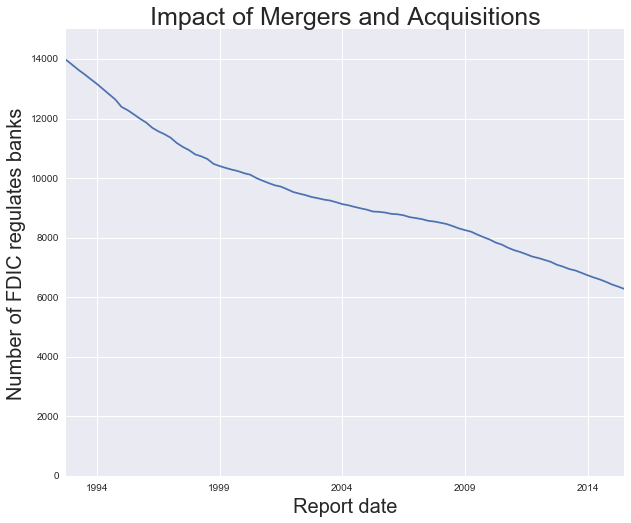

In [356]:
fig = plot_number_regulated_banks()
fig.savefig('./assets/img/number-fdic-regulated-banks.jpg')

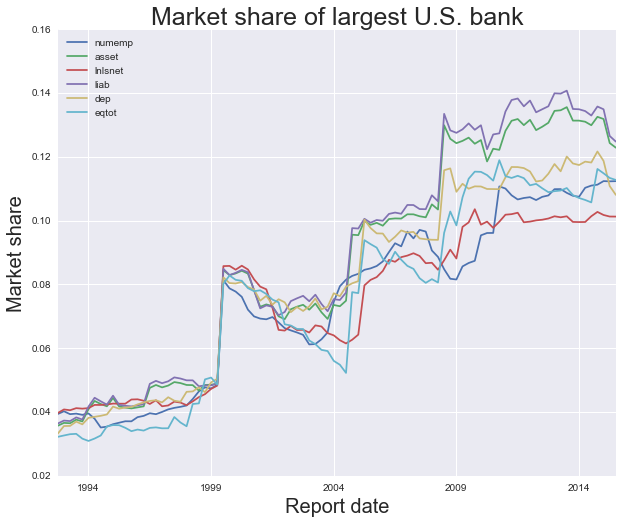

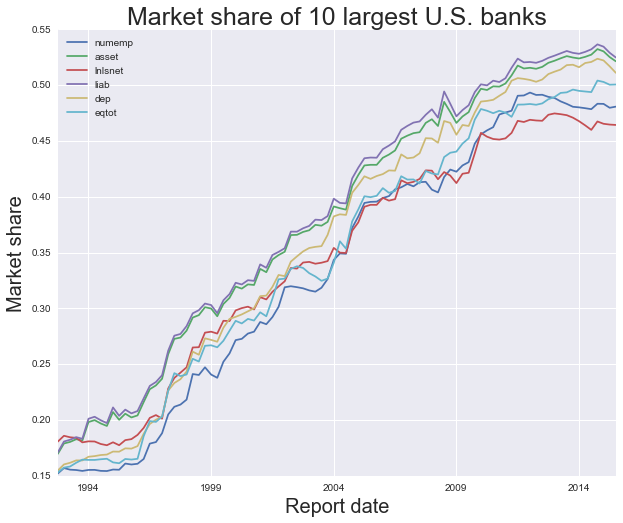

In [6]:
fig = plot_nlargest_bank_share(1)
fig.axes[0].set_title("Market share of largest U.S. bank", fontsize=25)
fig.savefig('./assets/img/largest-bank-market-share.jpg')

fig = plot_nlargest_bank_share(10)
fig.axes[0].set_title("Market share of 10 largest U.S. banks", fontsize=25)
fig.savefig('./assets/img/nlargest-banks-market-share.jpg')

<h2>Significant agglomeration within the U.S. banking sector...</h2>

<img src="./assets/img/number-fdic-regulated-banks.jpg" alt="Effect of M&A" width=1000>

<img src="./assets/img/largest-bank-market-share.jpg" alt="Market share of largest bank" width=1000>

<img src="./assets/img/nlargest-banks-market-share.jpg" alt="Market share of 10 largest banks" width=1000>

<h2> Summary </h2>
Major consolidation of the U.S. banking sector over the past 20+ years...
<ul>
  <li>Q1 1992: $\approx$ 14,000 banks in the data; largest bank (Citibank), controlled $\approx$ 4% of all U.S. banking assets.</li>
  <li>Q3 2015, $\approx$ 6,000 banks remain; largest bank (now JP Morgan-Chase), controlled $\approx$ 13% of all U.S. banking assets.</li>
  <li>"Jumps" in the share of assets and liabilities controlled by the largest U.S. bank all occurred because of mergers between large banks:
    <ul>
      <li>1999: Nations Bank (largest U.S. bank in 1999), merged with Bank of America.</li> 
      <li>2004: JPMorgan-Chase (the largest bank in 2003), purchased Bank One (6th largest bank).</li>
      <li>2008: JPMorgan-Chase acquired both Bear Stearns and Washington Mutual</li>
    </ul>
  </li>
  <li>"Jumps" in market shares also hint at another important stylized fact: there seems to be no preferred scale for bank mergers and acquisitions.</li>
</ul>

In [7]:
def plot_survival_functions(figsize=(12, 8), sharex=True, sharey=True):
    dates = fdic_sdi_panel.minor_axis

    fig, axes = plt.subplots(2, 3, figsize=figsize, sharex=sharex, sharey=sharey)
    for i, size_measure in enumerate(fdic_sdi_panel.items):
        ax = axes.flatten()[i]

        df = normalize_size_measure(size_measure)

        for t, date in enumerate(fdic_sdi_panel.minor_axis):
            series = df[date].dropna()
            ecdf = sm.distributions.ECDF(series)
            if t == 0:
                ax.plot(ecdf.x[1:-1], 1 - ecdf.y[1:-1], alpha=0.5, label="1992")
            elif t == (fdic_sdi_panel.minor_axis.size - 1):
                ax.plot(ecdf.x[1:-1], 1 - ecdf.y[1:-1], alpha=0.5, color='r', label="2015")
            else:
                ax.plot(ecdf.x[1:-1], 1 - ecdf.y[1:-1], alpha=0.01, color='k')

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()

        if i in [0, 3]:
            ax.set_ylabel(r'$1 - F(x)$', fontsize=20)
        if i in [3, 4, 5]:
            ax.set_xlabel("Report Date", fontsize=20)

        # map size measure variable to better title...
        if size_measure == 'asset':
            ax.set_title("Assets", fontsize=20)
        elif size_measure == 'dep':
            ax.set_title("Deposits", fontsize=20)
        elif size_measure == 'liab':
            ax.set_title("Liabilities", fontsize=20)
        elif size_measure == 'eqtot':
            ax.set_title("Equity", fontsize=20)
        elif size_measure == 'lnlsnet':
            ax.set_title("Loans", fontsize=20)
        else:
            ax.set_title("Employees", fontsize=20)
    fig.suptitle("Survival functions", x=0.5, y=1.05, fontsize=25)
    fig.tight_layout()
    
    return fig

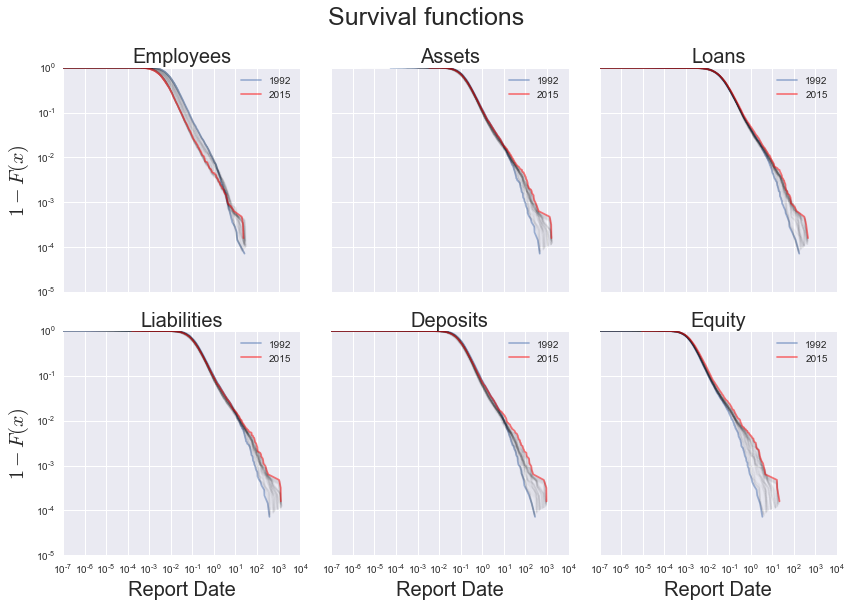

In [18]:
fig = plot_survival_functions()
fig.savefig('./assets/img/sf-various-size-measures.jpg', bbox_inches='tight')

<img src="./assets/img/sf-various-size-measures.jpg" alt="Survival functions for various size measures" width=1000>

<h2>Methodology</h2>

Follow the methodology advocated by <a href="http://arxiv.org/abs/0706.1062">Clauset et al (SIAM, 2009)...</a>

<h3> Maximum Likelihood Estimator </h3>

Assuming data $x_i,\ i=i,\dots,n$ are <em>independent</em>, then, for a given value of $x_{min}$, the maximum likelihood estimator for the scaling exponent is

$$ \hat{\alpha} = 1 +  n\left[\sum_{i=1}^{n}\mathrm{ln}\ \left(\frac{x_{i}}{x_{min}}\right)\right]^{-1}. $$

The maximum likelihood estimator is equivalent to the Hill Estimator widely used in Extreme Value statistics.

In [16]:
def parameter_estimation(base_date, normalize=True, method='bounded'):
    results = {}
    for size_measure in fdic_sdi_panel.items:
        results[size_measure] = {}
        df = normalize_size_measure(size_measure, base_date)
        for date in fdic_sdi_panel.minor_axis:
            data = df[date]
            fit = pyreto.distributions.Pareto.fit(data, scale=None, normalize=normalize, method=method)
            results[size_measure][date] = fit
    return results

In [17]:
estimation_results = parameter_estimation(base_date='2015-09-30', normalize=True, method='bounded')

But this maximum likelihood estimator holds only for a <em>given</em> value of $x_{min}$. The procedure for choosing $x_{min}$ is basically a brute force search:
<ol>
  <li>Choose a set of candidate threshold parameters, $\Theta$ from the observed data.</li>
  <li>For each $x_{min}^{c} \in \Theta$ obtain an estimate of the scaling exponent $\hat{\alpha}^{c}$ using maximum likelihood and then calculates the Kolmogorov-Smirnov (KS) distance between the empirical distribution of the data above $x_{min}^c$ and the theoretical distribution of a power law with parameters $\hat{\alpha}^{c}$ and $x_{min}^c$.</li>
  <li>Optimal choice for the threshold parameter, $x_{min}$, is the $x_{min}^{*} \in \Theta$ which minimizes the KS distance between the observed data above $x_{min}^{*}$ and the theoretical power law distribution with scaling exponent, $\hat{\alpha}^{*}$.</li>
</ol>

<p>In order to get estimates of parameter uncertainty that accurately take into account the flexibility introduced by the joint estimation of $\alpha$ and $x_{min}$, standard errors and confidence intervals for the parameter estimates are estimated using a basic non-parametric bootstrap procedure.</p>

<h1>Results</h1>

In [20]:
def plot_estimated_scaling_threshold(estimation_results, figsize=(12, 8), sharey=True):
    fig, axes = plt.subplots(2, 3, figsize=figsize, sharey=sharey)

    dates = fdic_sdi_panel.minor_axis
    for i, size_measure in enumerate(fdic_sdi_panel.items):
        ax = axes.flatten()[i]
        ax1 = ax.twinx()
        
        tmp_results = estimation_results[size_measure]
        n_tails = pd.Series({date: tmp_results[date].n_tail for date in dates})
        ns = fdic_sdi_panel[size_measure].count()
        tail_fractions = n_tails / ns
        xmins = pd.Series({date: tmp_results[date].params['scale'] for date in dates})
        xmins.plot(ax=ax)
        tail_fractions.plot(ax=ax1, color='r')

        # axis specific formatting
        if i in [0, 3]:
            ax.set_ylabel(r'$\hat{x}_{min}$', rotation=0, fontsize=20)
        if i in [3, 4, 5]:
            ax.set_xlabel("Report Date", fontsize=20)
        if i in [0, 1, 3, 4]:
            ax1.tick_params(axis='y', right='off', labelright='off')
        if i in [2, 5]:
            ax1.set_ylabel(r'$\frac{n_{tail}}{n}$', rotation=0, fontsize=20)
        ax1.set_ylim(0, 1)
        
        # map size measure variable to better title...
        if size_measure == 'asset':
            ax.set_title("Assets", fontsize=20)
        elif size_measure == 'dep':
            ax.set_title("Deposits", fontsize=20)
        elif size_measure == 'liab':
            ax.set_title("Liabilities", fontsize=20)
        elif size_measure == 'eqtot':
            ax.set_title("Equity", fontsize=20)
        elif size_measure == 'lnlsnet':
            ax.set_title("Loans", fontsize=20)
        else:
            ax.set_title("Employees", fontsize=20)
    
    fig.suptitle("Estimated Scaling Threshold", x=0.5, y=1.05, fontsize=25)
    fig.tight_layout()
    
    return fig

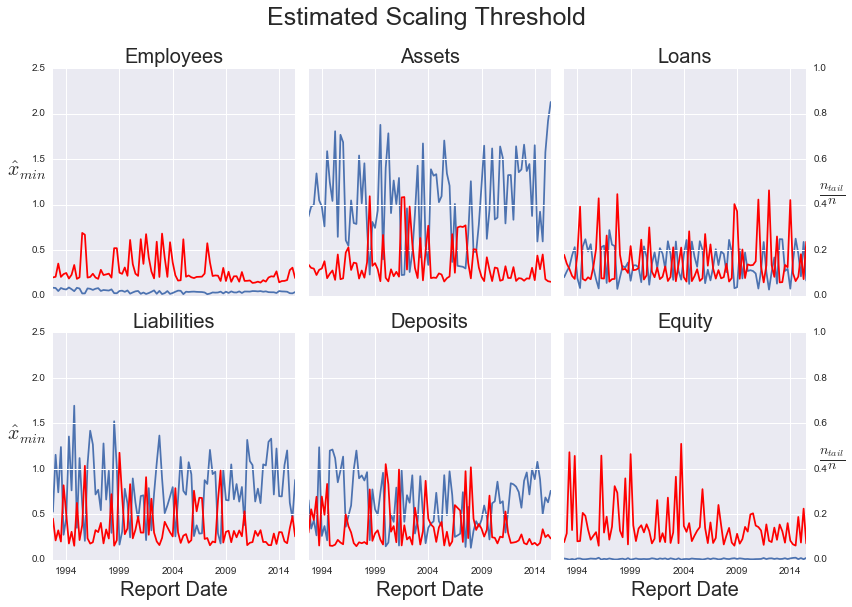

In [23]:
fig = plot_estimated_scaling_threshold(estimation_results)
fig.savefig('./assets/img/estimated-scaling-threshold.jpg', bbox_inches='tight')

In [13]:
def plot_estimated_scaling_exponents(estimation_results, figsize=(12, 8), sharey=True):
    fig, axes = plt.subplots(2, 3, figsize=figsize, sharey=sharey)

    dates = fdic_sdi_panel.minor_axis
    for i, size_measure in enumerate(fdic_sdi_panel.items):
        ax = axes.flatten()[i]
        ax1 = ax.twinx()
        
        tmp_results = estimation_results[size_measure]
        n_tails = pd.Series({date: tmp_results[date].n_tail for date in dates})
        ns = fdic_sdi_panel[size_measure].count()
        tail_fractions = n_tails / ns
        alphas = pd.Series({date: tmp_results[date].params['b'] + 1 for date in dates})
        alphas.plot(ax=ax)
        tail_fractions.plot(ax=ax1, color='r')
        
        # plot classic MLE confidence intervals...
        alpha_ses = pd.Series({date: tmp_results[date].standard_errors['b'] for date in dates})
        lower = alphas - 1.96 * alpha_ses
        upper = alphas + 1.96 * alpha_ses
        ax.fill_between(alpha_ses.index, lower, upper, color='grey', alpha=0.5)
        ax.axhline(2.0, color='k', linestyle='dashed', label="Zipf's Law")

        # axis specific formatting
        if i in [0, 3]:
            ax.set_ylabel(r'$\hat{\alpha}$', rotation=0, fontsize=20)
        if i in [3, 4, 5]:
            ax.set_xlabel("Report Date", fontsize=20)
        if i in [0, 1, 3, 4]:
            ax1.tick_params(axis='y', right='off', labelright='off')
        if i in [2, 5]:
            ax1.set_ylabel(r'$\frac{n_{tail}}{n}$', rotation=0, fontsize=20)
        ax1.set_ylim(0, 1)
        
        # map size measure variable to better title...
        if size_measure == 'asset':
            ax.set_title("Assets", fontsize=20)
        elif size_measure == 'dep':
            ax.set_title("Deposits", fontsize=20)
        elif size_measure == 'liab':
            ax.set_title("Liabilities", fontsize=20)
        elif size_measure == 'eqtot':
            ax.set_title("Equity", fontsize=20)
        elif size_measure == 'lnlsnet':
            ax.set_title("Loans", fontsize=20)
        else:
            ax.set_title("Employees", fontsize=20)
    
    fig.suptitle("Estimated Scaling Exponents", x=0.5, y=1.05, fontsize=25)
    fig.tight_layout()
    
    return fig

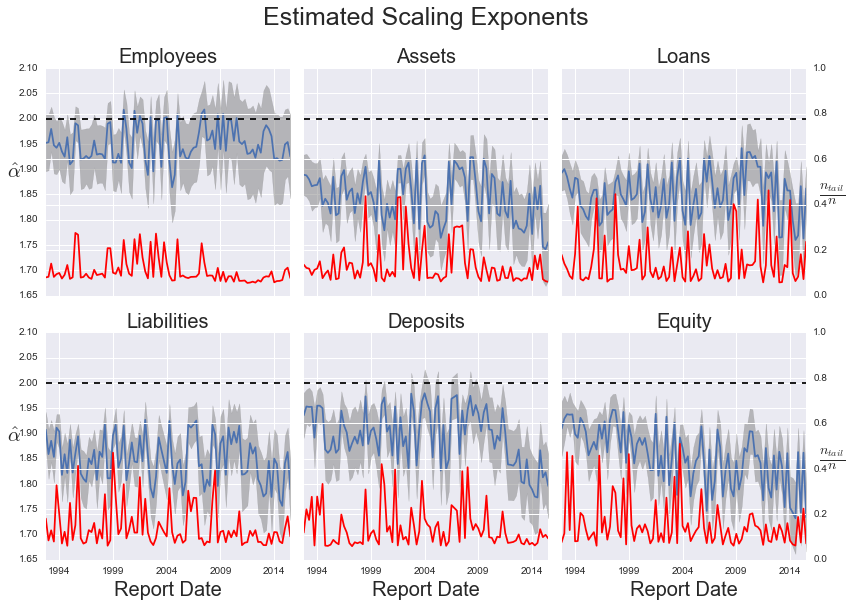

In [19]:
fig = plot_estimated_scaling_exponents(estimation_results)
#fig.savefig('./assets/img/estimated-scaling-exponents.jpg', bbox_inches='tight')

<img src="./assets/img/estimated-scaling-exponents.jpg" alt="Estimated scaling exponents">

<img src="./assets/img/estimated-scaling-threshold.jpg" alt="Estimated scaling thresholds">

<h2>Summary</h2>
<ul>
  <li>For most size measures, in most quarters, the tail of the size distribution is so heavy that the mean of the best-fitting power law model is infinite! There is no such thing as an "average" sized large bank in the U.S.!</li>
  <li>Only measure of bank size even reasonably consistent with Zipf's Law is number of employees.</li>
  <li>For most size measures, there are clear negative trends in $\hat{\alpha}$ indicating that U.S banking sector balance sheets are becoming increasingly concentrated.
</ul>

<strong>Conclusion:</strong> Power law distribution with $\hat{\alpha} < 2$ is a pretty good model for the upper tail of the size distribution of U.S. banks.

<h2> Questions? </h2>